# Setup


In [1]:
import os
import numpy as np
import random
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt


# Reproductibilité + chemins

In [2]:


SEED = 42
random.seed(SEED)
np.random.seed(SEED)



#COCOBG_PATH = "/content/drive/MyDrive/Colab Notebooks/Domain Shift/coco_background_embeddings.npy"
#DOTABG_PATH = "/content/drive/MyDrive/Colab Notebooks/Domain Shift/dota_background_embeddings.npy"
#DOTA_PATH = "/content/drive/MyDrive/Colab Notebooks/Domain Shift/dota__embeddings.npy"
#DIOR_PATH = "/content/drive/MyDrive/Colab Notebooks/Domain Shift/dior_embeddings.npy"

# Options
TEST_SIZE = 0.2
VAL_SIZE = 0.2     # sur le train, pour early stop MLP (si activé)
STRATIFY = True

#print("COCO_PATH:", COCO_PATH)
#print("DOTA_PATH:", DOTA_PATH)
#print("DIOR_PATH:", DIOR_PATH)

# Chargement embeddings (npy/npz/pt)

In [4]:
from pathlib import Path

def load_embedding_file(fp: Path) -> np.ndarray:
    x = np.load(fp)
    x = np.asarray(x)

    # Accepte (D,), (1,D), (D,1)
    if x.ndim == 2:
        if x.shape[0] == 1:
            x = x[0]
        elif x.shape[1] == 1:
            x = x[:, 0]
        else:
            raise ValueError(f"{fp} has shape {x.shape}, expected a single embedding.")
    elif x.ndim != 1:
        raise ValueError(f"{fp} has ndim={x.ndim}, expected 1D embedding.")

    return x.astype(np.float32)

def load_dataset_from_dir(root_dir: str, label: int, pattern="*.npy"):
    root = Path(root_dir)
    files = sorted(root.glob(pattern))
    if len(files) == 0:
        raise FileNotFoundError(f"No files found in {root_dir} with pattern {pattern}")

    X_list = []
    for fp in files:
        X_list.append(load_embedding_file(fp))

    # Vérifie dimension cohérente
    D = X_list[0].shape[0]
    for i, x in enumerate(X_list):
        if x.shape[0] != D:
            raise ValueError(f"Dim mismatch at {files[i]}: got {x.shape[0]}, expected {D}")

    X = np.stack(X_list, axis=0)              # (N, D)
    y = np.full((X.shape[0],), label)         # (N,)
    return X, y, files

In [5]:
X_dota, y_dota, files_dota = load_dataset_from_dir("embeddings/DOTA", label=0)
X_dior, y_dior, files_dior = load_dataset_from_dir("embeddings/DIOR", label=1)


# Préparation dataset binaire “domaine”

In [ ]:


X = np.vstack([X_dota, X_dior]).astype(np.float32)
y = np.concatenate([y_dota, y_dior])

print("Total (DOTA vs DIOR):", X.shape, "labels:", np.bincount(y))

Total (DOTA vs DIOR): (63060, 2048) labels: [54087  8973]


# Split train/test + normalisation

In [7]:
strat = y if STRATIFY else None
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=strat
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Train:", X_train_s.shape, np.bincount(y_train))
print("Test :", X_test_s.shape,  np.bincount(y_test))


Train: (50448, 2048) [43270  7178]
Test : (12612, 2048) [10817  1795]


# Logistic Regression

In [8]:
logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=-1
)
logreg.fit(X_train_s, y_train)

proba_test = logreg.predict_proba(X_test_s)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

acc = accuracy_score(y_test, pred_test)
auc = roc_auc_score(y_test, proba_test)

print(f"[LogReg] Accuracy: {acc:.4f} | ROC-AUC: {auc:.4f}")


[LogReg] Accuracy: 0.9497 | ROC-AUC: 0.9803


# Proxy A-distance

In [9]:
err = 1.0 - acc
pad = 2.0 * (1.0 - 2.0 * err)
pad = float(np.clip(pad, 0.0, 2.0))

print(f"Error ε: {err:.4f}")
print(f"Proxy A-distance (PAD): {pad:.4f}  (0=proche, 2=très différent)")


Error ε: 0.0503
Proxy A-distance (PAD): 1.7989  (0=proche, 2=très différent)


# Courbe ROC (LogReg)

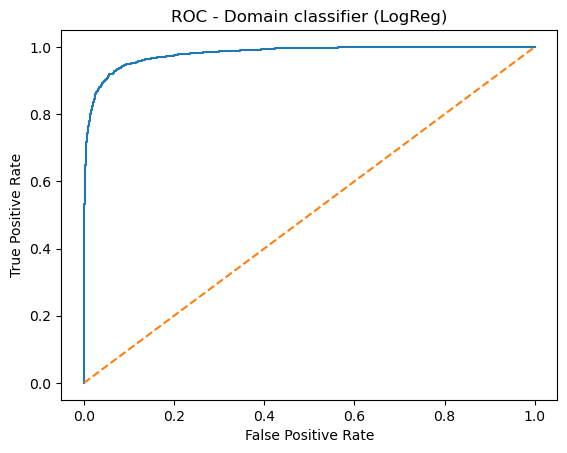

In [10]:
fpr, tpr, thr = roc_curve(y_test, proba_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Domain classifier (LogReg)")
plt.show()


# MLP PyTorch

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# Split train -> train/val
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_s, y_train, test_size=VAL_SIZE, random_state=SEED, stratify=y_train
)

X_tr_t  = torch.tensor(X_tr, dtype=torch.float32)
y_tr_t  = torch.tensor(y_tr, dtype=torch.float32)  # BCE expects float
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32)
X_te_t  = torch.tensor(X_test_s, dtype=torch.float32)
y_te_t  = torch.tensor(y_test, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_tr_t, y_tr_t), batch_size=256, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=512, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_te_t, y_te_t), batch_size=512, shuffle=False)

class MLP(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # logits
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)

model = MLP(X.shape[1]).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
crit = nn.BCEWithLogitsLoss()

def eval_loader(loader):
    model.eval()
    probs, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            p = torch.sigmoid(logits)
            probs.append(p.detach().cpu().numpy())
            ys.append(yb.detach().cpu().numpy())
    probs = np.concatenate(probs)
    ys = np.concatenate(ys).astype(int)
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(ys, preds)
    auc = roc_auc_score(ys, probs)
    return acc, auc, probs, ys

best_val_auc = -1
best_state = None
patience = 10
pat = 0
EPOCHS = 100

for epoch in range(1, EPOCHS+1):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()

    val_acc, val_auc, _, _ = eval_loader(val_loader)
    if val_auc > best_val_auc + 1e-4:
        best_val_auc = val_auc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | val_acc={val_acc:.4f} val_auc={val_auc:.4f} | best_val_auc={best_val_auc:.4f}")

    if pat >= patience:
        print("Early stopping.")
        break

# restore best
model.load_state_dict({k: v.to(device) for k, v in best_state.items()})


device: cpu
Epoch 001 | val_acc=0.9701 val_auc=0.9873 | best_val_auc=0.9873
Epoch 005 | val_acc=0.9722 val_auc=0.9890 | best_val_auc=0.9907
Epoch 010 | val_acc=0.9782 val_auc=0.9917 | best_val_auc=0.9917
Epoch 015 | val_acc=0.9772 val_auc=0.9911 | best_val_auc=0.9917
Epoch 020 | val_acc=0.9758 val_auc=0.9908 | best_val_auc=0.9918
Epoch 025 | val_acc=0.9752 val_auc=0.9905 | best_val_auc=0.9918
Early stopping.


<All keys matched successfully>

# Évaluation MLP + PAD

[MLP] Accuracy: 0.9756 | ROC-AUC: 0.9919
Error ε: 0.0244
Proxy A-distance (PAD): 1.9023


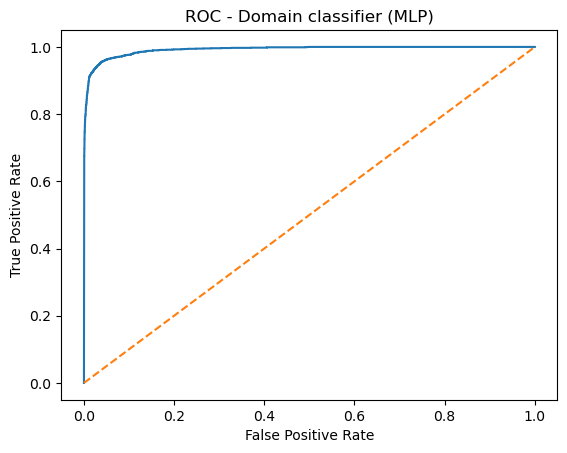

In [12]:
test_acc, test_auc, test_probs, test_ys = eval_loader(test_loader)

print(f"[MLP] Accuracy: {test_acc:.4f} | ROC-AUC: {test_auc:.4f}")

err = 1.0 - test_acc
pad = 2.0 * (1.0 - 2.0 * err)
pad = float(np.clip(pad, 0.0, 2.0))

print(f"Error ε: {err:.4f}")
print(f"Proxy A-distance (PAD): {pad:.4f}")

fpr, tpr, _ = roc_curve(test_ys, test_probs)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Domain classifier (MLP)")
plt.show()


MLP Domain Classifier

In [14]:
from typing import List, Dict

class DomainDiscriminator(nn.Sequential):
    def __init__(self, in_feature: int, hidden_size: int, batch_norm=True, sigmoid=True):
        final_layer = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
        super(DomainDiscriminator, self).__init__(
            nn.Linear(in_feature, hidden_size),
            nn.BatchNorm1d(hidden_size) if batch_norm else nn.Identity(),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size) if batch_norm else nn.Identity(),
            nn.ReLU(),
            final_layer
        )

    def get_parameters(self) -> List[Dict]:
        return [{'params': self.parameters()}]

Training Domain Discriminator...
Epoch 001 | val_acc=0.9676 val_auc=0.9887 | best_val_auc=0.9887
Epoch 005 | val_acc=0.9778 val_auc=0.9907 | best_val_auc=0.9910
Epoch 010 | val_acc=0.9755 val_auc=0.9902 | best_val_auc=0.9915
Epoch 015 | val_acc=0.9811 val_auc=0.9921 | best_val_auc=0.9928
Epoch 020 | val_acc=0.9767 val_auc=0.9909 | best_val_auc=0.9928
Epoch 025 | val_acc=0.9798 val_auc=0.9928 | best_val_auc=0.9929
Epoch 030 | val_acc=0.9814 val_auc=0.9930 | best_val_auc=0.9931
Epoch 035 | val_acc=0.9810 val_auc=0.9930 | best_val_auc=0.9931
Early stopping.

[Domain Discriminator] Accuracy: 0.9799 | ROC-AUC: 0.9945
Error ε: 0.0201
Proxy A-distance (PAD): 1.9198


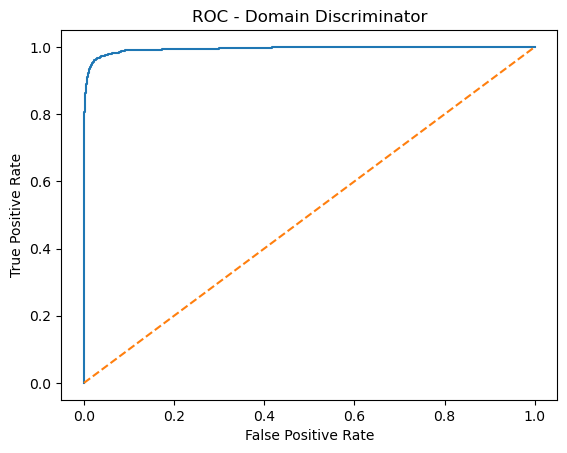

In [15]:
# Instantiate and train the DomainDiscriminator
discriminator = DomainDiscriminator(in_feature=X.shape[1], hidden_size=256).to(device)
d_opt = torch.optim.AdamW(discriminator.parameters(), lr=1e-3, weight_decay=1e-4)
d_crit = nn.BCELoss() # for probabilities

# Using the same data loaders as for MLP

def eval_discriminator(loader):
    discriminator.eval()
    probs, ys = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            p = discriminator(xb)
            probs.append(p.detach().cpu().numpy())
            ys.append(yb.detach().cpu().numpy())
    probs = np.concatenate(probs)
    ys = np.concatenate(ys).astype(int)
    preds = (probs >= 0.5).astype(int)
    acc = accuracy_score(ys, preds)
    auc = roc_auc_score(ys, probs)
    return acc, auc, probs, ys

best_val_auc_d = -1
best_state_d = None
patience_d = 10
pat_d = 0
EPOCHS_d = 100

print("Training Domain Discriminator...")
for epoch in range(1, EPOCHS_d + 1):
    discriminator.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        d_opt.zero_grad()
        probs = discriminator(xb)
        loss = d_crit(probs, yb.unsqueeze(1)) # Ensure yb has same shape as probs
        loss.backward()
        d_opt.step()

    val_acc_d, val_auc_d, _, _ = eval_discriminator(val_loader)
    if val_auc_d > best_val_auc_d + 1e-4:
        best_val_auc_d = val_auc_d
        best_state_d = {k: v.detach().cpu().clone() for k, v in discriminator.state_dict().items()}
        pat_d = 0
    else:
        pat_d += 1

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | val_acc={val_acc_d:.4f} val_auc={val_auc_d:.4f} | best_val_auc={best_val_auc_d:.4f}")

    if pat_d >= patience_d:
        print("Early stopping.")
        break

# restore best
discriminator.load_state_dict({k: v.to(device) for k, v in best_state_d.items()})

test_acc_d, test_auc_d, test_probs_d, test_ys_d = eval_discriminator(test_loader)

print(f"\n[Domain Discriminator] Accuracy: {test_acc_d:.4f} | ROC-AUC: {test_auc_d:.4f}")

err_d = 1.0 - test_acc_d
pad_d = 2.0 * (1.0 - 2.0 * err_d)
pad_d = float(np.clip(pad_d, 0.0, 2.0))

print(f"Error ε: {err_d:.4f}")
print(f"Proxy A-distance (PAD): {pad_d:.4f}")

fpr_d, tpr_d, _ = roc_curve(test_ys_d, test_probs_d)
plt.figure()
plt.plot(fpr_d, tpr_d)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - Domain Discriminator")
plt.show()